# Tutorial CNN with CIFAR-10 dataset

This is tutorial of Keras API usage for CNN 

Download a CIFAR-10 dataset

```
cd /tmp
curl -L -O https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
tar -zxvf cifar-10-python.tar.gz
```

The dataset consist of images 32x32, each image has 3 channels for color and it is labeled with 10 classes

In [1]:
WIDTH = 32
HEIGHT = 32
CHANNELS = 3
CLASSES = 10


In [2]:
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/Users/dmitry.kolesnikov/devel/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Helper function to load CIFAR images and correcponding labels into `numpy` arrays 

In [3]:
def load(file):    
    data = pickle.load(open(file, "rb"), encoding='latin1') 
    return np.array(data["data"], dtype='float32'), np.array(data["labels"], dtype='int32')

A categorical value to converted into vector of classes

In [4]:
def asclass(i):
    data = np.zeros(CLASSES, dtype='float32')
    data[i] = 1
    return data

The data is organised in 5 batches on the disk. 

> a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.

We need to build a 32x32x3 tensor out of it, thus we first group color channles together 3x32x32 and then tanspose it to required dimension. Similar approach is applied to build a test data set. As the result, we have 50K images for training and 10K images for validation


In [5]:
X = np.empty([0, WIDTH, HEIGHT, CHANNELS])
Y = np.empty([0, CLASSES])
    
for i in range(1, 6):
    data, labels = load("/tmp/cifar-10-batches-py/data_batch_" + str(i))
    data = data.reshape((len(data), CHANNELS, WIDTH, HEIGHT)).transpose(0,2,3,1)
    labels = labels.reshape((len(labels), 1))
    klass = np.apply_along_axis(asclass, 1, labels)
    X = np.concatenate([X, data], axis=0)
    Y = np.concatenate([Y, klass], axis=0)

Xtest, Ytest = load("/tmp/cifar-10-batches-py/test_batch")
Xtest = Xtest.reshape((len(data), CHANNELS, WIDTH, HEIGHT)).transpose(0,2,3,1)
Ytest = Ytest.reshape((len(Ytest), 1))
Ytest = np.apply_along_axis(asclass, 1, Ytest)

print("x = ", X.shape, Xtest.shape)
print("y = ", Y.shape, Ytest.shape)

x =  (50000, 32, 32, 3) (10000, 32, 32, 3)
y =  (50000, 10) (10000, 10)


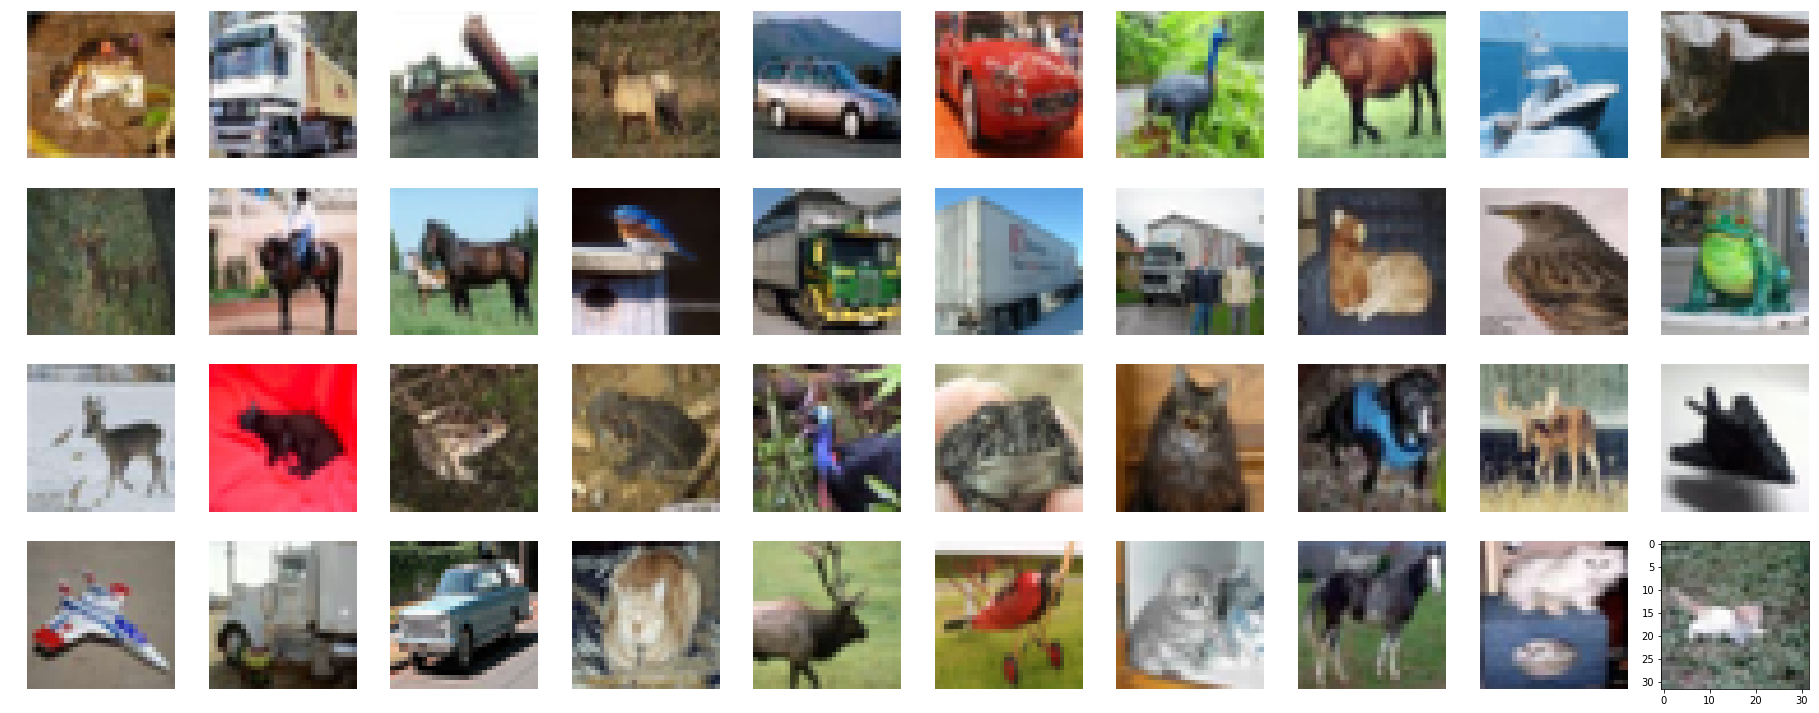

In [6]:
plt.figure(figsize=(WIDTH, HEIGHT))
for i in range(0,40):
    plt.axis("off")
    plt.subplot(10, 10, i + 1)

    pixels = np.array(X[i], dtype='int32')
    plt.imshow(pixels, interpolation='nearest')
    
plt.show()

# Keras CNN implementation

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation
from keras.optimizers import Adam
from keras import backend as K

Using TensorFlow backend.


In [8]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation = 'relu', 
   input_shape=(WIDTH, HEIGHT, CHANNELS),
   data_format="channels_last"
))
model.add(Conv2D(32, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same', activation = 'relu'))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(0.5))

model.add(Dense(CLASSES))
model.add(Activation('softmax'))


model.compile(
    optimizer = Adam(lr = 1e-4), 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [9]:
model.fit(X, Y,
   batch_size=100,
   epochs=10,
   validation_data=(Xtest, Ytest),
   shuffle=True
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 171s 3ms/step - loss: 5.1028 - acc: 0.2098 - val_loss: 1.8906 - val_acc: 0.3496
Epoch 2/10
50000/50000 [==============================] - 177s 4ms/step - loss: 1.7991 - acc: 0.3457 - val_loss: 1.5942 - val_acc: 0.4372
Epoch 3/10
50000/50000 [==============================] - 176s 4ms/step - loss: 1.6146 - acc: 0.4103 - val_loss: 1.4850 - val_acc: 0.4750
Epoch 4/10
50000/50000 [==============================] - 174s 3ms/step - loss: 1.5020 - acc: 0.4525 - val_loss: 1.3742 - val_acc: 0.5101
Epoch 5/10
50000/50000 [==============================] - 155s 3ms/step - loss: 1.4249 - acc: 0.4830 - val_loss: 1.2806 - val_acc: 0.5457
Epoch 6/10
50000/50000 [==============================] - 162s 3ms/step - loss: 1.3498 - acc: 0.5143 - val_loss: 1.2399 - val_acc: 0.5652
Epoch 7/10
50000/50000 [==============================] - 167s 3ms/step - loss: 1.2899 - acc: 0.5382 - val_loss: 1.1935 - 

Save model and weights

In [10]:
model.save("/tmp/keras-cifar-10.h5")

In [11]:
scores = model.evaluate(Xtest, Ytest, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 11s 1ms/step
Test loss: 1.068508590888977
Test accuracy: 0.6254


In [12]:
a  = 512
b  = 554
labels = model.predict(Xtest[a:b]).argmax(axis=-1)

print(labels)

[6 1 5 6 8 9 3 8 7 7 9 7 0 6 4 8 8 6 9 5 9 5 6 6 6 6 8 9 1 7 6 7 5 9 1 6 6
 5 5 2 8 5]


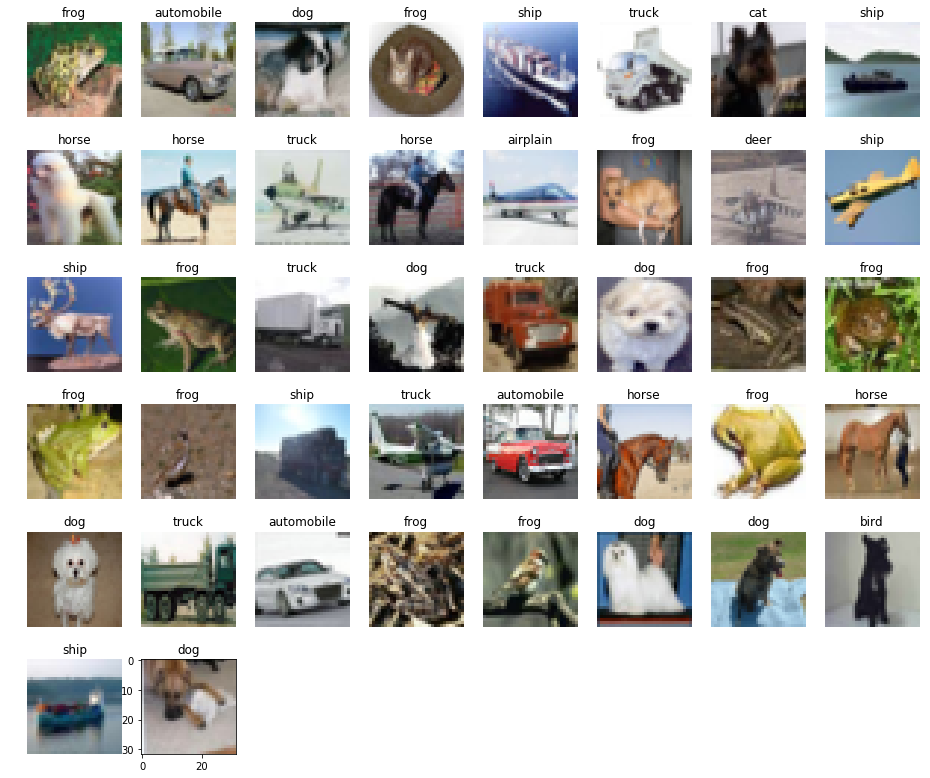

In [13]:
def isa(i):
    if i == 0:
        return 'airplain'
    elif i == 1:
        return 'automobile'
    elif i == 2:
        return 'bird'
    elif i == 3:
        return 'cat'
    elif i == 4:
        return 'deer'
    elif i == 5:
        return 'dog'
    elif i == 6:
        return 'frog'
    elif i == 7:
        return 'horse'
    elif i == 8:
        return 'ship'
    elif i == 9:
        return 'truck'
    else:
        return '-'



plt.figure(figsize=(16, 16))
for i in range(0, b-a):
    plt.axis("off")
    plt.subplot(7, 8, i + 1)

    pixels = np.array(Xtest[a + i], dtype='int32')

    plt.title('{label}'.format(label=isa(labels[i])))
    plt.imshow(pixels, interpolation='nearest')
    
plt.show()

/Users/dmitry.kolesnikov/devel/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


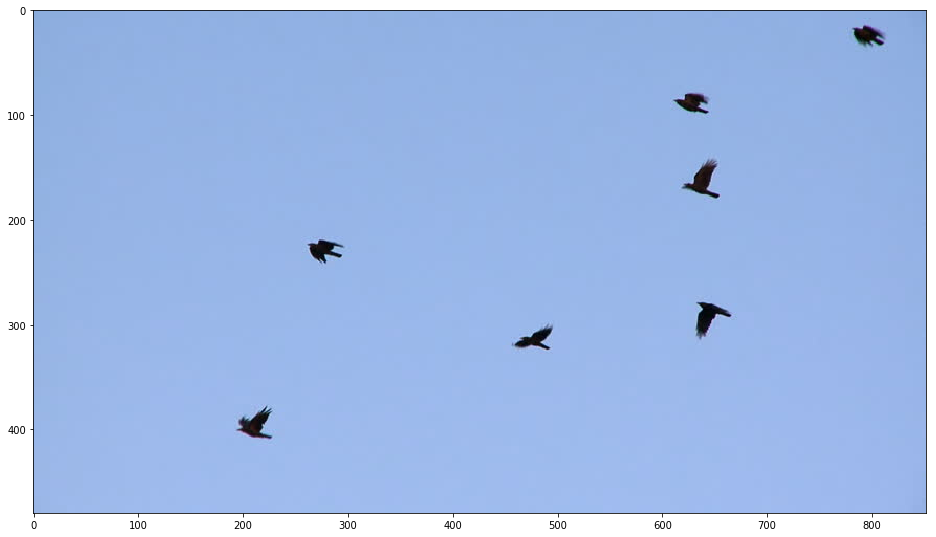

In [15]:
from scipy import misc
from skimage import transform

#cars = misc.imread('./png/cars-on-the-road.png')
cars = misc.imread('./png/birds-in-the-sky.png')
# cars = misc.imread('./png/dogs-and-cats.png')


# cars = transform.rescale(cars, 0.5)

plt.figure(num=None, figsize=(16, 16), dpi=72, facecolor='w', edgecolor='k')
plt.imshow(cars)
plt.show()

In [16]:
from skimage.util.shape import view_as_windows

shift = 4

patch = view_as_windows(cars, (32, 32, 3), step = shift)
print(patch.shape)

(113, 206, 1, 32, 32, 3)


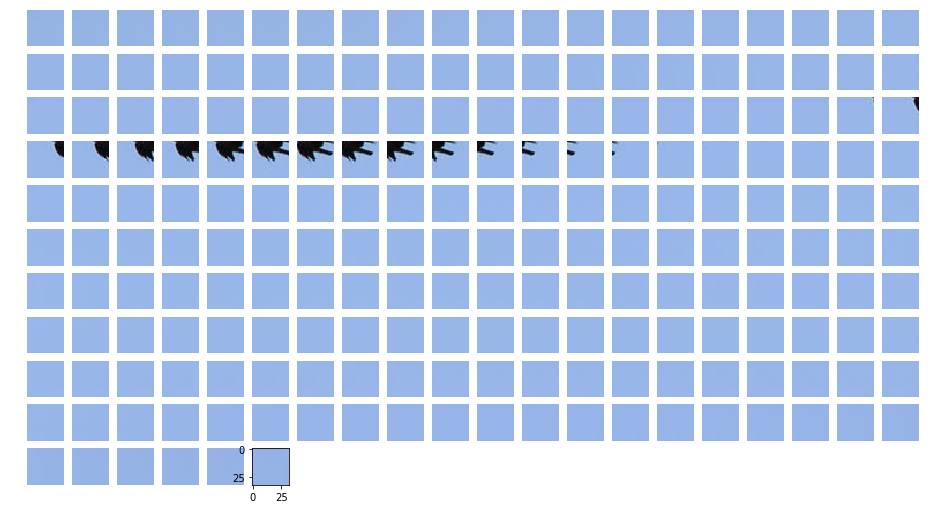

In [17]:
i, j, _, _, _, _ = patch.shape

plt.figure(figsize=(16, 16))
for xi in range(0, j):
    plt.axis("off")
    plt.subplot(20, 20 , xi + 1)
    plt.imshow(patch[i//2][xi][0])

plt.show()

In [ ]:
import matplotlib.patches as patches

job = patch.reshape((i*j*1, 32, 32, 3))
spot = labels = model.predict(job).argmax(axis=-1)

spot = spot.reshape((i,j))

fig,ax = plt.subplots(figsize=(16, 16), dpi=72)
ax.imshow(cars)


for xi in range(0, i):
    for yi in range (0, j):
        if spot[xi][yi] == 2:
            rect = patches.Rectangle((yi * shift, xi * shift),32,32,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
#        elif spot[xi][yi] == 5:
#            rect = patches.Rectangle((yi * shift, xi * shift),32,32,linewidth=1,edgecolor='b',facecolor='none')
#            ax.add_patch(rect)

plt.show()        
            